<a href="https://colab.research.google.com/github/park-sunjung/project-h/blob/main/%ED%81%B4%EB%A1%9C%EC%9D%B4%EB%93%9C_%EA%B2%BD%EB%A7%88%EC%9E%A5%EB%B3%84_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%ED%9B%88%EB%A0%A8%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1순위 (핵심)
!pip install xgboost              # XGBoost 모델
!pip install scikit-learn         # 대부분 기본 설치됨
!pip install pandas numpy         # 대부분 기본 설치됨

# 2순위 (시각화)
!pip install seaborn             # 고급 시각화
!pip install matplotlib          # 대부분 기본 설치됨

# 3순위 (선택사항)
!pip install lightgbm            # LightGBM (XGBoost 대안)
!pip install catboost            # CatBoost (범주형 특화)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 17.5 MB/s eta 0:00:00


In [ ]:
# =====================================================
# 🏇 Google Colab용 경마장별 경마 예측 모델 훈련기 (수정버전)
# 서울/부산/제주 각각 독립 모델 생성 + 경주거리 Feature 포함
# =====================================================

import pandas as pd
import numpy as np
import os
import pickle
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ===== 🔥 여기에 한글 폰트 설정 추가! =====
try:
    # 한글 폰트 설정 (에러 방지)
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False
    print("✅ 기본 폰트 설정 완료")
except:
    print("⚠️ 폰트 설정 건너뜀")
# ========================================

# Colab 환경 확인
try:
    from google.colab import files, drive
    IN_COLAB = True
    print("✅ Google Colab 환경 감지됨")
except ImportError:
    IN_COLAB = False
    print("❌ 로컬 환경 - Colab에서 실행하세요!")

# 필수 패키지 설치
def install_packages():
    """필수 패키지 설치"""
    print("📦 필수 패키지 설치 중...")
    import subprocess
    packages = [
        'xgboost',
        'scikit-learn',
        'seaborn'
    ]

    for package in packages:
        try:
            subprocess.check_call(['pip', 'install', package])
            print(f"✅ {package} 설치 완료")
        except:
            print(f"⚠️ {package} 설치 건너뜀 (이미 설치됨)")

class ColabRacetrackTrainer:
    """Google Colab용 경마장별 모델 훈련기 (경주거리 포함)"""

    def __init__(self):
        self.racetrack_models = {}
        self.racetrack_names = {
            'seoul': '서울',
            'busan': '부산',
            'jeju': '제주',
            'combined': '전체통합'  # 통합 모델 추가
        }

        # 모델 파라미터 (Colab GPU 활용)
        self.rf_params = {
            'n_estimators': 200,
            'max_depth': 15,
            'min_samples_split': 10,
            'min_samples_leaf': 5,
            'max_features': 'sqrt',
            'n_jobs': -1,  # Colab CPU 모두 활용
            'random_state': 42
        }

        self.xgb_params = {
            'n_estimators': 300,
            'max_depth': 8,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'n_jobs': -1,  # Colab CPU 모두 활용
            'random_state': 42,
            'tree_method': 'hist',  # 메모리 효율적
            'device': 'cpu'  # Colab CPU 사용
        }

        print("🎯 경마장별 모델 훈련 시스템 초기화 완료")
        print("💻 Google Colab 최적화 설정 적용")
        print("🆕 경주거리 Feature 포함 버전")

    def upload_datasets(self):
        """Colab에서 데이터셋 업로드"""
        if not IN_COLAB:
            print("❌ Google Colab에서만 작동합니다!")
            return None

        print("📁 경마장별 ML 데이터셋을 업로드하세요!")
        print("=" * 50)
        print("필요한 파일들:")
        print("   - seoul_ml_dataset.csv (서울)")
        print("   - busan_ml_dataset.csv (부산)")
        print("   - jeju_ml_dataset.csv (제주)")
        print("   - all_tracks_dataset.csv (통합) ← 이것도 업로드하면 4개 모델 생성!")
        print("-" * 50)

        uploaded = files.upload()

        datasets = {}
        for filename, content in uploaded.items():
            if 'seoul' in filename.lower():
                datasets['seoul'] = filename
                print(f"✅ 서울 데이터셋: {filename}")
            elif 'busan' in filename.lower():
                datasets['busan'] = filename
                print(f"✅ 부산 데이터셋: {filename}")
            elif 'jeju' in filename.lower():
                datasets['jeju'] = filename
                print(f"✅ 제주 데이터셋: {filename}")
            elif 'all_tracks' in filename.lower():
                datasets['combined'] = filename
                print(f"✅ 통합 데이터셋: {filename}")

        return datasets

    def load_dataset(self, filename, track_name):
        """데이터셋 로딩 및 기본 정보 출력"""
        try:
            print(f"\n📊 {track_name} 데이터셋 로딩 중...")
            df = pd.read_csv(filename, encoding='utf-8')

            print(f"   📈 총 레코드: {len(df):,}건")
            print(f"   📋 총 컬럼: {len(df.columns)}개")

            # 경주거리 포함 확인
            if '경주거리' in df.columns:
                distance_dist = df['경주거리'].value_counts().head()
                print(f"   🏃 경주거리 분포: {dict(distance_dist)}")
            else:
                print("   ⚠️ 경주거리 컬럼 없음")

            # 거리 카테고리 확인
            if '거리_카테고리' in df.columns:
                cat_dist = df['거리_카테고리'].value_counts()
                print(f"   📏 거리별 분포: {dict(cat_dist)}")

            # Target 분포 확인
            if 'target_순위' in df.columns:
                print(f"   🎯 평균 순위: {df['target_순위'].mean():.1f}위")
                print(f"   🏆 우승률: {df['target_우승'].mean()*100:.1f}%")
                print(f"   🥉 복승률: {df['target_복승'].mean()*100:.1f}%")

            return df

        except Exception as e:
            print(f"   ❌ {track_name} 로딩 실패: {e}")
            return None

    def prepare_features(self, df, track_name):
        """Feature 준비 및 선별 (경주거리 포함)"""
        print(f"\n⚙️ {track_name} Feature 준비 중...")

        # Target 설정
        if 'target_순위' not in df.columns:
            print("   ❌ target_순위 컬럼이 없습니다!")
            return None, None, None

        # Feature 컬럼 자동 선별
        exclude_cols = [
            '마번', '기수명', '조교사명', '경마장', '경마장_코드',
            'target_순위', 'target_우승', 'target_복승',
            '거리_카테고리'  # 더미변수로 변환되므로 원본 제외
        ]

        feature_cols = [col for col in df.columns if col not in exclude_cols]

        # 수치형 컬럼만 선택 (경주거리 관련 포함)
        numeric_features = []
        distance_features = []
        combo_features = []

        for col in feature_cols:
            if df[col].dtype in ['int64', 'float64']:
                numeric_features.append(col)

                # 특성별 분류
                if '거리' in col:
                    distance_features.append(col)
                elif '조합' in col or '기수' in col:
                    combo_features.append(col)

        print(f"   📋 전체 Feature: {len(numeric_features)}개")
        print(f"   🏃 거리 관련: {len(distance_features)}개 {distance_features}")
        print(f"   🤝 조합 관련: {len(combo_features)}개")

        # Feature 행렬과 Target 벡터 생성
        X = df[numeric_features].copy()
        y = df['target_순위'].copy()

        # 결측치 확인 및 처리
        missing_counts = X.isnull().sum()
        if missing_counts.sum() > 0:
            print(f"   🔧 결측치 처리 중: {missing_counts.sum()}개")
            X = X.fillna(X.median())

        # 경주거리 특별 처리
        if '경주거리' in X.columns:
            distance_stats = X['경주거리'].describe()
            print(f"   📏 경주거리 범위: {distance_stats['min']:.0f}m ~ {distance_stats['max']:.0f}m")

            # 이상한 거리값 필터링
            valid_distance = (X['경주거리'] >= 800) & (X['경주거리'] <= 3000)
            X = X[valid_distance]
            y = y[valid_distance]
            print(f"   ✅ 거리 필터링 후: {len(X):,}건")

        # 이상치 제거 (순위 기준)
        valid_mask = (y >= 1) & (y <= 20)
        X = X[valid_mask]
        y = y[valid_mask]

        print(f"   ✅ 최종 데이터: {len(X):,}건, {len(numeric_features)}개 Feature")

        return X, y, numeric_features

    def analyze_distance_impact(self, df, track_name):
        """거리별 성과 분석"""
        print(f"\n📏 {track_name} 거리별 성과 분석...")

        if '경주거리' not in df.columns:
            print("   ⚠️ 경주거리 정보 없음")
            return

        # 거리별 평균 순위
        distance_perf = df.groupby('경주거리').agg({
            'target_순위': ['count', 'mean'],
            'target_우승': 'mean'
        }).round(2)

        distance_perf.columns = ['경주수', '평균순위', '우승률']
        distance_perf = distance_perf[distance_perf['경주수'] >= 50]  # 50경주 이상만

        print(f"   📊 주요 거리별 성과:")
        for distance, row in distance_perf.head(8).iterrows():
            print(f"      {distance:4.0f}m: {row['경주수']:4.0f}경주, 평균 {row['평균순위']:.1f}위, 우승률 {row['우승률']*100:.1f}%")

    def train_racetrack_model(self, X, y, features, track_name):
        """단일 경마장 모델 훈련 (경주거리 포함)"""
        print(f"\n🤖 {track_name} 모델 훈련 시작")
        print("=" * 50)

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=5, labels=False)
        )

        print(f"📊 훈련 세트: {len(X_train):,}건")
        print(f"📊 테스트 세트: {len(X_test):,}건")

        models = {}
        results = {}

        # 1. Random Forest 훈련
        print(f"\n🌲 {track_name} Random Forest 훈련 중...")
        rf_model = RandomForestRegressor(**self.rf_params)

        import time
        start_time = time.time()
        rf_model.fit(X_train, y_train)
        rf_time = time.time() - start_time

        # RF 평가
        rf_pred = rf_model.predict(X_test)
        rf_r2 = r2_score(y_test, rf_pred)
        rf_mae = mean_absolute_error(y_test, rf_pred)

        models['random_forest'] = rf_model
        results['random_forest'] = {
            'r2': rf_r2,
            'mae': rf_mae,
            'train_time': rf_time
        }

        print(f"   ✅ RF 완료: R² = {rf_r2:.4f}, MAE = {rf_mae:.3f}, 시간 = {rf_time:.1f}초")

        # 2. XGBoost 훈련
        print(f"\n🚀 {track_name} XGBoost 훈련 중...")
        xgb_model = xgb.XGBRegressor(**self.xgb_params)

        start_time = time.time()
        xgb_model.fit(X_train, y_train)
        xgb_time = time.time() - start_time

        # XGB 평가
        xgb_pred = xgb_model.predict(X_test)
        xgb_r2 = r2_score(y_test, xgb_pred)
        xgb_mae = mean_absolute_error(y_test, xgb_pred)

        models['xgboost'] = xgb_model
        results['xgboost'] = {
            'r2': xgb_r2,
            'mae': xgb_mae,
            'train_time': xgb_time
        }

        print(f"   ✅ XGB 완료: R² = {xgb_r2:.4f}, MAE = {xgb_mae:.3f}, 시간 = {xgb_time:.1f}초")

        # 3. 최고 성능 모델 선택
        if xgb_r2 > rf_r2:
            best_model = xgb_model
            best_name = 'xgboost'
            best_r2 = xgb_r2
            best_mae = xgb_mae
            best_pred = xgb_pred
        else:
            best_model = rf_model
            best_name = 'random_forest'
            best_r2 = rf_r2
            best_mae = rf_mae
            best_pred = rf_pred

        print(f"\n🏆 {track_name} 최고 성능 모델: {best_name}")
        print(f"   📈 R² 스코어: {best_r2:.4f}")
        print(f"   ⏱️ MAE: {best_mae:.3f}순위")

        # 4. Feature 중요도 분석 (거리 관련 하이라이트)
        if hasattr(best_model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': features,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=False)

            print(f"\n📊 {track_name} 주요 Feature (Top 15):")
            for i, (_, row) in enumerate(feature_importance.head(15).iterrows()):
                # 거리 관련 Feature 하이라이트
                marker = "🏃" if "거리" in row['feature'] else "🤝" if "조합" in row['feature'] or "기수" in row['feature'] else "  "
                print(f"   {i+1:2d}. {marker} {row['feature']:<25}: {row['importance']:.4f}")

            # 거리 관련 Feature들의 중요도 합계
            distance_features = feature_importance[feature_importance['feature'].str.contains('거리')]
            if len(distance_features) > 0:
                distance_importance = distance_features['importance'].sum()
                print(f"\n🏃 거리 관련 Feature 총 중요도: {distance_importance:.4f}")
        else:
            feature_importance = None

        # 5. 거리별 예측 성능 분석
        if '경주거리' in X_test.columns:
            self.analyze_distance_predictions(X_test, y_test, best_pred, track_name)

        # 6. 성능 시각화 (Colab용) - 거리 분석 추가
        plt.figure(figsize=(16, 8))

        # 예측 vs 실제
        plt.subplot(2, 3, 1)
        plt.scatter(y_test, best_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('실제 순위')
        plt.ylabel('예측 순위')
        plt.title(f'{track_name} 예측 vs 실제 (R² = {best_r2:.4f})')

        # Feature 중요도
        plt.subplot(2, 3, 2)
        if feature_importance is not None:
            top_features = feature_importance.head(12)
            colors = ['red' if '거리' in f else 'blue' if '조합' in f or '기수' in f else 'gray'
                     for f in top_features['feature']]
            plt.barh(range(len(top_features)), top_features['importance'], color=colors)
            plt.yticks(range(len(top_features)), [f[:15] for f in top_features['feature']])
            plt.xlabel('Feature 중요도')
            plt.title(f'{track_name} Feature 중요도 (빨강:거리, 파랑:조합)')
            plt.gca().invert_yaxis()

        # 거리별 성능 (있다면)
        if '경주거리' in X_test.columns:
            plt.subplot(2, 3, 3)
            distance_groups = pd.DataFrame({
                'distance': X_test['경주거리'],
                'actual': y_test,
                'predicted': best_pred
            })

            # 주요 거리별 MAE
            major_distances = distance_groups['distance'].value_counts().head(6).index
            distance_mae = []
            distance_labels = []

            for dist in major_distances:
                mask = distance_groups['distance'] == dist
                if mask.sum() >= 10:  # 10경주 이상만
                    mae = mean_absolute_error(
                        distance_groups[mask]['actual'],
                        distance_groups[mask]['predicted']
                    )
                    distance_mae.append(mae)
                    distance_labels.append(f'{int(dist)}m')

            if distance_mae:
                plt.bar(distance_labels, distance_mae)
                plt.xlabel('경주거리')
                plt.ylabel('MAE')
                plt.title(f'{track_name} 거리별 예측 오차')
                plt.xticks(rotation=45)

        # 순위별 정확도
        plt.subplot(2, 3, 4)
        rank_accuracy = []
        rank_labels = []
        for rank in range(1, 11):
            mask = (y_test == rank)
            if mask.sum() >= 5:
                pred_in_range = np.abs(best_pred[mask] - rank) <= 1  # ±1 순위 내
                accuracy = pred_in_range.mean() * 100
                rank_accuracy.append(accuracy)
                rank_labels.append(f'{rank}위')

        if rank_accuracy:
            plt.bar(rank_labels, rank_accuracy)
            plt.xlabel('실제 순위')
            plt.ylabel('정확도 (%)')
            plt.title(f'{track_name} 순위별 예측 정확도 (±1순위)')
            plt.xticks(rotation=45)

        # 모델 비교
        plt.subplot(2, 3, 5)
        model_names = ['RF', 'XGB']
        r2_scores = [results['random_forest']['r2'], results['xgboost']['r2']]
        colors = ['green' if best_name == 'random_forest' else 'lightgreen',
                 'green' if best_name == 'xgboost' else 'lightgreen']
        plt.bar(model_names, r2_scores, color=colors)
        plt.ylabel('R² 스코어')
        plt.title(f'{track_name} 모델 성능 비교')
        plt.ylim(0, 1)

        # 잔차 분포
        plt.subplot(2, 3, 6)
        residuals = y_test - best_pred
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.xlabel('잔차 (실제 - 예측)')
        plt.ylabel('빈도')
        plt.title(f'{track_name} 잔차 분포')
        plt.axvline(0, color='red', linestyle='--')

        plt.tight_layout()
        plt.show()

        # 결과 저장
        track_result = {
            'track_name': track_name,
            'best_model': best_model,
            'best_model_name': best_name,
            'models': models,
            'results': results,
            'feature_names': features,
            'feature_importance': feature_importance,
            'test_data': {
                'X_test': X_test,
                'y_test': y_test,
                'predictions': best_pred
            },
            'performance': {
                'r2_score': best_r2,
                'mae': best_mae,
                'data_size': len(X),
                'feature_count': len(features),
                'distance_features': len([f for f in features if '거리' in f])
            }
        }

        return track_result

    def analyze_distance_predictions(self, X_test, y_test, predictions, track_name):
        """거리별 예측 성능 상세 분석"""
        print(f"\n🏃 {track_name} 거리별 예측 성능:")

        distance_analysis = pd.DataFrame({
            'distance': X_test['경주거리'],
            'actual': y_test,
            'predicted': predictions
        })

        # 주요 거리별 성능
        major_distances = distance_analysis['distance'].value_counts().head(8).index

        for dist in major_distances:
            mask = distance_analysis['distance'] == dist
            subset = distance_analysis[mask]

            if len(subset) >= 10:  # 10경주 이상만
                mae = mean_absolute_error(subset['actual'], subset['predicted'])
                r2 = r2_score(subset['actual'], subset['predicted'])
                print(f"   {int(dist):4d}m: {len(subset):3d}경주, MAE {mae:.3f}, R² {r2:.3f}")

    def train_all_racetracks(self, datasets):
        """모든 경마장 모델 훈련 + 통합 모델 (거리 분석 포함)"""
        print("\n🚀 경마장별 + 통합 모델 훈련 시작!")
        print("=" * 60)

        # 1단계: 개별 경마장 모델 훈련
        for track_key, filename in datasets.items():
            if track_key == 'combined':  # 통합은 나중에
                continue

            track_name = self.racetrack_names.get(track_key, track_key)

            # 데이터 로딩
            df = self.load_dataset(filename, track_name)
            if df is None:
                continue

            # 거리별 성과 분석
            self.analyze_distance_impact(df, track_name)

            # Feature 준비
            X, y, features = self.prepare_features(df, track_name)
            if X is None:
                continue

            # 모델 훈련
            result = self.train_racetrack_model(X, y, features, track_name)
            self.racetrack_models[track_key] = result

        # 2단계: 통합 모델 훈련 (있다면)
        if 'combined' in datasets:
            print(f"\n🌟 통합 모델 훈련 시작!")
            print("=" * 50)

            # 통합 데이터 로딩
            df = self.load_dataset(datasets['combined'], '전체통합')
            if df is not None:
                # 거리별 성과 분석
                self.analyze_distance_impact(df, '전체통합')

                # 통합 모델 특별 분석
                self.analyze_combined_model_insights(df)

                # Feature 준비
                X, y, features = self.prepare_features(df, '전체통합')
                if X is not None:
                    # 통합 모델 훈련
                    result = self.train_racetrack_model(X, y, features, '전체통합')
                    self.racetrack_models['combined'] = result

        return len(self.racetrack_models) > 0

    def generate_comparison_report(self):
        """경마장별 성능 비교 리포트 (거리 Feature 포함)"""
        print("\n" + "=" * 80)
        print("📊 경마장별 모델 성능 비교 리포트 (경주거리 포함)")
        print("=" * 80)

        if not self.racetrack_models:
            print("❌ 훈련된 모델이 없습니다!")
            return

        # 성능 비교 테이블
        comparison_data = []
        for track_key, result in self.racetrack_models.items():
            comparison_data.append({
                '경마장': result['track_name'],
                'R² 스코어': result['performance']['r2_score'],
                'MAE': result['performance']['mae'],
                '데이터 크기': result['performance']['data_size'],
                'Feature 수': result['performance']['feature_count'],
                '거리 Feature': result['performance']['distance_features'],
                '최고 모델': result['best_model_name']
            })

        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('R² 스코어', ascending=False)

        print("🏆 성능 순위:")
        for i, (_, row) in enumerate(comparison_df.iterrows(), 1):
            print(f"   {i}. {row['경마장']:>4}: R² {row['R² 스코어']:.4f}, MAE {row['MAE']:.3f} ({row['최고 모델']}, 거리F:{row['거리 Feature']}개)")

        print(f"\n📊 전체 평균:")
        print(f"   평균 R² 스코어: {comparison_df['R² 스코어'].mean():.4f}")
        print(f"   평균 MAE: {comparison_df['MAE'].mean():.3f}")
        print(f"   평균 거리 Feature: {comparison_df['거리 Feature'].mean():.1f}개")

        # 거리 Feature 중요도 분석
        print(f"\n🏃 거리 관련 Feature 중요도 분석:")
        for track_key, result in self.racetrack_models.items():
            track_name = result['track_name']
            feature_importance = result['feature_importance']

            if feature_importance is not None:
                distance_features = feature_importance[feature_importance['feature'].str.contains('거리')]
                if len(distance_features) > 0:
                    top_distance = distance_features.iloc[0]
                    total_distance_importance = distance_features['importance'].sum()
                    print(f"   {track_name}: 최고 거리F '{top_distance['feature']}' ({top_distance['importance']:.4f}), 총합 {total_distance_importance:.4f}")

        # 성능 시각화 (확장)
        plt.figure(figsize=(16, 8))

        # R² 스코어 비교
        plt.subplot(2, 3, 1)
        plt.bar(comparison_df['경마장'], comparison_df['R² 스코어'])
        plt.title('경마장별 R² 스코어 비교')
        plt.ylabel('R² 스코어')
        plt.ylim(0, 1)

        # MAE 비교
        plt.subplot(2, 3, 2)
        plt.bar(comparison_df['경마장'], comparison_df['MAE'])
        plt.title('경마장별 MAE 비교')
        plt.ylabel('MAE (순위)')

        # 데이터 크기 비교
        plt.subplot(2, 3, 3)
        plt.bar(comparison_df['경마장'], comparison_df['데이터 크기']/1000)
        plt.title('경마장별 데이터 크기')
        plt.ylabel('데이터 크기 (천 건)')

        # Feature 수 비교
        plt.subplot(2, 3, 4)
        plt.bar(comparison_df['경마장'], comparison_df['Feature 수'])
        plt.title('경마장별 총 Feature 수')
        plt.ylabel('Feature 수')

        # 거리 Feature 수 비교
        plt.subplot(2, 3, 5)
        plt.bar(comparison_df['경마장'], comparison_df['거리 Feature'])
        plt.title('경마장별 거리 Feature 수')
        plt.ylabel('거리 Feature 수')

        # 모델 분포
        plt.subplot(2, 3, 6)
        model_counts = comparison_df['최고 모델'].value_counts()
        plt.pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%')
        plt.title('최고 성능 모델 분포')

        plt.tight_layout()
        plt.show()

        print("=" * 80)

    def save_models(self):
        """훈련된 모델들 저장 (Colab 다운로드)"""
        if not IN_COLAB:
            print("❌ Google Colab에서만 작동합니다!")
            return

        print("\n💾 모델 저장 및 다운로드 중...")

        # 모델 정보 요약 파일도 생성
        model_info = {
            'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'total_models': len(self.racetrack_models),
            'has_combined_model': 'combined' in self.racetrack_models,
            'models': {}
        }

        for track_key, result in self.racetrack_models.items():
            track_name = result['track_name']
            model_type = "통합" if track_key == 'combined' else "개별"

            # 모델 파일 저장
            model_filename = f"{track_key}_model.pkl"
            with open(model_filename, 'wb') as f:
                pickle.dump(result, f)

            # 모델 정보 수집
            model_info['models'][track_key] = {
                'track_name': track_name,
                'model_type': model_type,
                'r2_score': result['performance']['r2_score'],
                'mae': result['performance']['mae'],
                'best_model': result['best_model_name'],
                'feature_count': result['performance']['feature_count'],
                'distance_features': result['performance']['distance_features'],
                'data_size': result['performance']['data_size']
            }

            print(f"✅ {model_type} {track_name} 모델 저장: {model_filename}")

        # 모델 정보 파일 저장
        import json
        with open('model_info.json', 'w', encoding='utf-8') as f:
            json.dump(model_info, f, ensure_ascii=False, indent=2)

        # Colab에서 다운로드
        for track_key in self.racetrack_models.keys():
            model_filename = f"{track_key}_model.pkl"
            files.download(model_filename)

        files.download('model_info.json')

        print("🎉 모든 모델 + 정보 파일 다운로드 완료!")

def main():
    """메인 실행 함수"""
    print("🏇 Google Colab용 경마장별 모델 훈련기 (경주거리 포함)")
    print("=" * 60)

    # 패키지 설치
    install_packages()

    # 훈련기 초기화
    trainer = ColabRacetrackTrainer()

    # 데이터셋 업로드
    datasets = trainer.upload_datasets()
    if not datasets:
        print("❌ 데이터셋 업로드 실패!")
        return

    # 모든 경마장 모델 훈련
    success = trainer.train_all_racetracks(datasets)

    if success:
        # 성능 비교 리포트
        trainer.generate_comparison_report()

        # 모델 저장 및 다운로드
        trainer.save_models()

        print("\n🎉 모든 모델 훈련 완료!")
        print("📦 다운로드된 파일들:")
        if 'seoul' in trainer.racetrack_models:
            print("   - seoul_model.pkl (서울 개별)")
        if 'busan' in trainer.racetrack_models:
            print("   - busan_model.pkl (부산 개별)")
        if 'jeju' in trainer.racetrack_models:
            print("   - jeju_model.pkl (제주 개별)")
        if 'combined' in trainer.racetrack_models:
            print("   - combined_model.pkl (전체 통합) 🌟")
        print("   - model_info.json (모델 정보)")
        print(f"\n🏆 총 {len(trainer.racetrack_models)}개 모델 생성 완료!")
    else:
        print("\n❌ 모델 훈련 실패!")

# Colab에서 바로 실행
if IN_COLAB:
    print("🚀 Google Colab에서 실행 준비 완료!")
    print("main() 함수를 호출하여 시작하세요!")
else:
    print("⚠️ 이 코드는 Google Colab에서 실행해야 합니다!")

# 실행: main()

✅ 기본 폰트 설정 완료
✅ Google Colab 환경 감지됨
🚀 Google Colab에서 실행 준비 완료!
main() 함수를 호출하여 시작하세요!


In [ ]:
# 누락된 메서드 추가
def analyze_combined_model_insights(self, df):
    """통합 모델 특별 분석"""
    print(f"\n🌟 통합 모델 특별 분석...")

    # 경마장별 데이터 분포
    if '경마장' in df.columns:
        track_dist = df['경마장'].value_counts()
        print(f"   📊 경마장별 데이터 분포:")
        for track, count in track_dist.items():
            print(f"      {track}: {count:,}건 ({count/len(df)*100:.1f}%)")

    # 경마장별 평균 순위
    if '경마장' in df.columns and 'target_순위' in df.columns:
        track_performance = df.groupby('경마장').agg({
            'target_순위': 'mean',
            'target_우승': 'mean'
        }).round(3)

        print(f"   🎯 경마장별 평균 성과:")
        for track, row in track_performance.iterrows():
            print(f"      {track}: 평균 {row['target_순위']:.1f}위, 우승률 {row['target_우승']*100:.1f}%")

    # 경마장별 거리 분포
    if '경주거리' in df.columns and '경마장' in df.columns:
        print(f"   🏃 경마장별 주요 거리:")
        for track in df['경마장'].unique():
            track_data = df[df['경마장'] == track]
            distances = track_data['경주거리'].value_counts().head(3)
            distance_str = ", ".join([f"{int(d)}m({c})" for d, c in distances.items()])
            print(f"      {track}: {distance_str}")

# 클래스에 메서드 추가
ColabRacetrackTrainer.analyze_combined_model_insights = analyze_combined_model_insights

print("✅ 누락된 메서드 추가 완료!")

✅ 누락된 메서드 추가 완료!


🏇 Google Colab용 경마장별 모델 훈련기 (경주거리 포함)
📦 필수 패키지 설치 중...
✅ xgboost 설치 완료
✅ scikit-learn 설치 완료
✅ seaborn 설치 완료
🎯 경마장별 모델 훈련 시스템 초기화 완료
💻 Google Colab 최적화 설정 적용
🆕 경주거리 Feature 포함 버전
📁 경마장별 ML 데이터셋을 업로드하세요!
필요한 파일들:
   - seoul_ml_dataset.csv (서울)
   - busan_ml_dataset.csv (부산)
   - jeju_ml_dataset.csv (제주)
   - all_tracks_dataset.csv (통합) ← 이것도 업로드하면 4개 모델 생성!
--------------------------------------------------


Saving all_tracks_dataset.csv to all_tracks_dataset (3).csv
Saving busan_ml_dataset.csv to busan_ml_dataset (3).csv
Saving jeju_ml_dataset.csv to jeju_ml_dataset (3).csv
Saving seoul_ml_dataset.csv to seoul_ml_dataset (3).csv
✅ 통합 데이터셋: all_tracks_dataset (3).csv
✅ 부산 데이터셋: busan_ml_dataset (3).csv
✅ 제주 데이터셋: jeju_ml_dataset (3).csv
✅ 서울 데이터셋: seoul_ml_dataset (3).csv

🚀 경마장별 + 통합 모델 훈련 시작!

📊 부산 데이터셋 로딩 중...
   📈 총 레코드: 38,865건
   📋 총 컬럼: 27개
   🏃 경주거리 분포: {1200.0: np.int64(12444), 1400.0: np.int64(8844), 1600.0: np.int64(5561), 1800.0: np.int64(5165), 1300.0: np.int64(4759)}
   🎯 평균 순위: 6.2위
   🏆 우승률: 9.0%
   🥉 복승률: 27.1%

📏 부산 거리별 성과 분석...
   📊 주요 거리별 성과:
      1000m: 1538경주, 평균 6.0위, 우승률 9.0%
      1200m: 12444경주, 평균 6.2위, 우승률 9.0%
      1300m: 4759경주, 평균 6.0위, 우승률 9.0%
      1400m: 8844경주, 평균 6.2위, 우승률 9.0%
      1600m: 5561경주, 평균 6.2위, 우승률 9.0%
      1800m: 5165경주, 평균 6.1위, 우승률 9.0%
      2000m:  518경주, 평균 6.0위, 우승률 9.0%

⚙️ 부산 Feature 준비 중...
   📋 전체 Feature: 16개
   🏃 거리 관련: 3개 

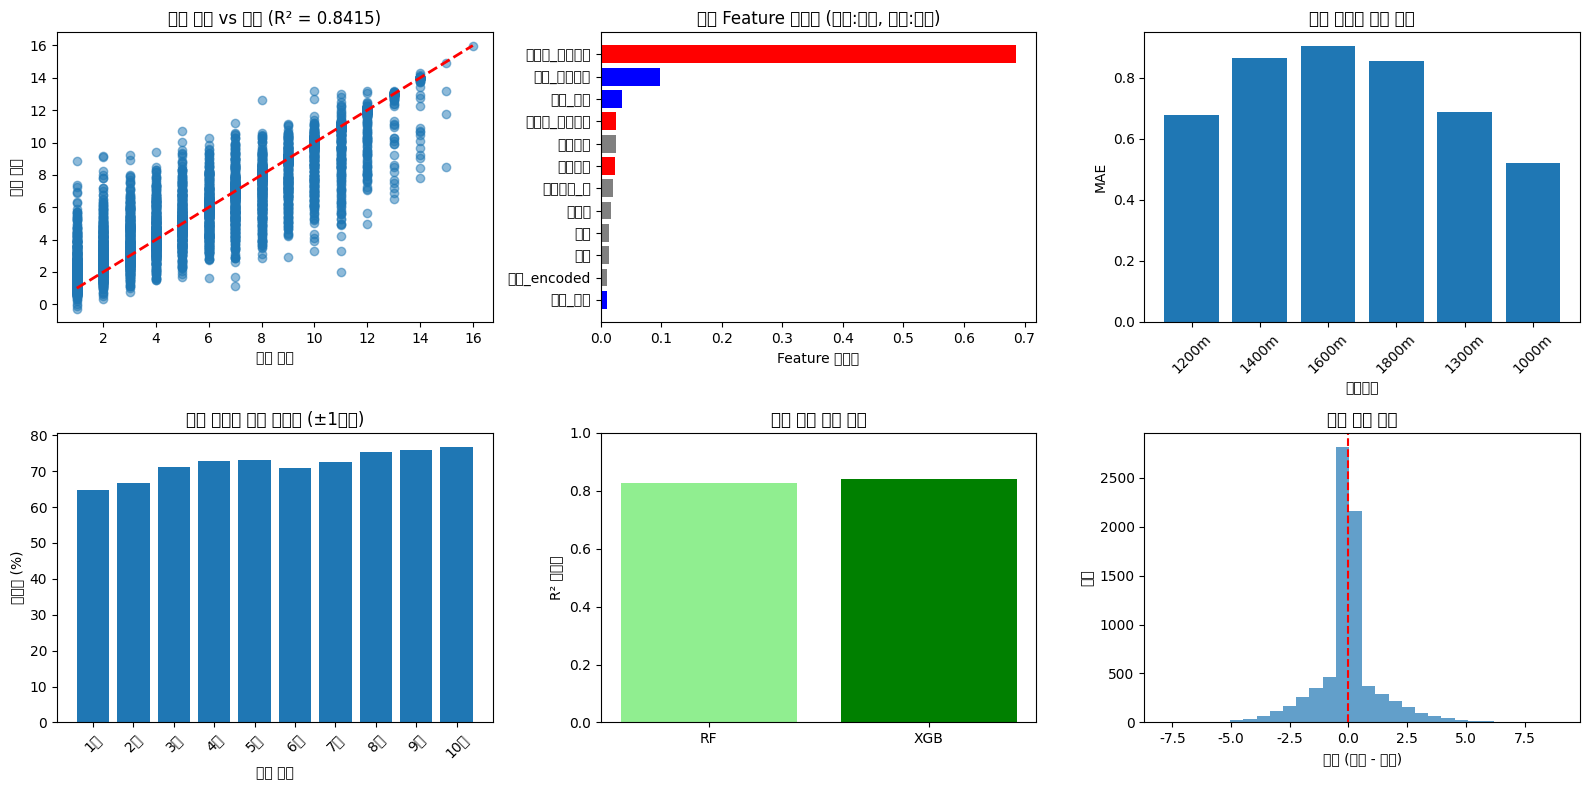


📊 제주 데이터셋 로딩 중...
   📈 총 레코드: 34,071건
   📋 총 컬럼: 27개
   🏃 경주거리 분포: {1000: np.int64(10065), 1110: np.int64(6658), 800: np.int64(6372), 900: np.int64(4929), 1200: np.int64(3674)}
   🎯 평균 순위: 5.5위
   🏆 우승률: 10.1%
   🥉 복승률: 30.2%

📏 제주 거리별 성과 분석...
   📊 주요 거리별 성과:
       800m: 6372경주, 평균 5.4위, 우승률 10.0%
       900m: 4929경주, 평균 5.4위, 우승률 10.0%
      1000m: 10065경주, 평균 5.6위, 우승률 10.0%
      1110m: 6658경주, 평균 5.6위, 우승률 10.0%
      1200m: 3674경주, 평균 5.6위, 우승률 10.0%
      1300m:  261경주, 평균 5.3위, 우승률 11.0%
      1400m: 1432경주, 평균 5.3위, 우승률 10.0%
      1610m:  375경주, 평균 5.1위, 우승률 11.0%

⚙️ 제주 Feature 준비 중...
   📋 전체 Feature: 16개
   🏃 거리 관련: 3개 ['경주거리', '거리별_조합출전', '거리별_조합순위']
   🤝 조합 관련: 3개
   📏 경주거리 범위: 800m ~ 1800m
   ✅ 거리 필터링 후: 34,071건
   ✅ 최종 데이터: 34,071건, 16개 Feature

🤖 제주 모델 훈련 시작
📊 훈련 세트: 27,256건
📊 테스트 세트: 6,815건

🌲 제주 Random Forest 훈련 중...
   ✅ RF 완료: R² = 0.6440, MAE = 1.255, 시간 = 1.2초

🚀 제주 XGBoost 훈련 중...
   ✅ XGB 완료: R² = 0.6700, MAE = 1.212, 시간 = 0.8초

🏆 제주 최고 성능 모델: xgboost
   📈 R

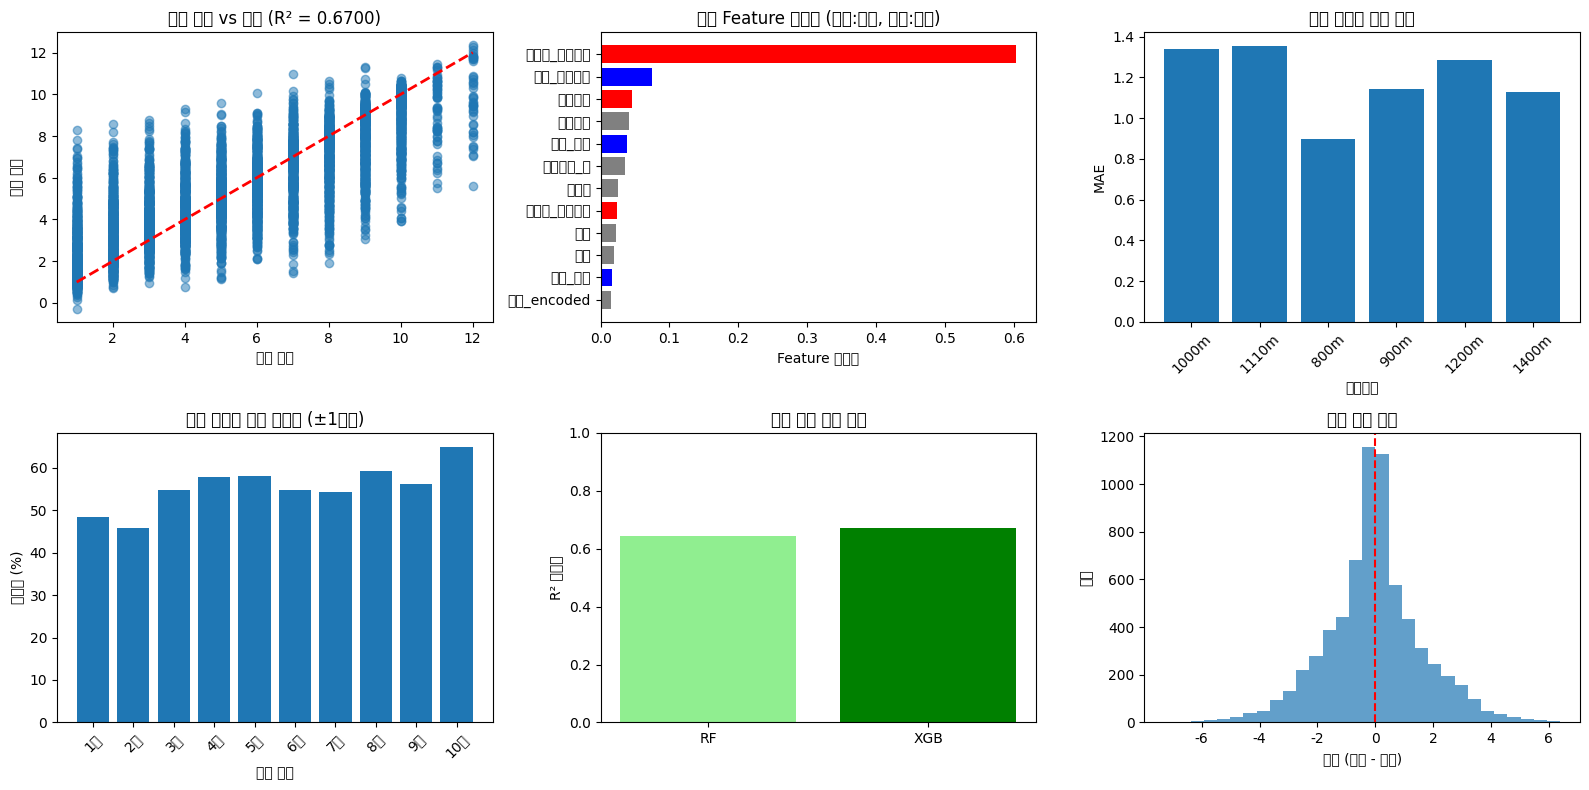


📊 서울 데이터셋 로딩 중...
   📈 총 레코드: 54,762건
   📋 총 컬럼: 27개
   🏃 경주거리 분포: {1200.0: np.int64(18901), 1400.0: np.int64(11887), 1300.0: np.int64(9035), 1800.0: np.int64(4894), 1700.0: np.int64(4498)}
   🎯 평균 순위: 6.1위
   🏆 우승률: 9.2%
   🥉 복승률: 27.6%

📏 서울 거리별 성과 분석...
   📊 주요 거리별 성과:
      1000m: 2592경주, 평균 6.0위, 우승률 9.0%
      1200m: 18901경주, 평균 6.2위, 우승률 9.0%
      1300m: 9035경주, 평균 6.0위, 우승률 9.0%
      1400m: 11887경주, 평균 6.1위, 우승률 9.0%
      1600m: 1795경주, 평균 5.3위, 우승률 10.0%
      1700m: 4498경주, 평균 5.9위, 우승률 9.0%
      1800m: 4894경주, 평균 6.0위, 우승률 9.0%
      1900m:   91경주, 평균 5.7위, 우승률 10.0%

⚙️ 서울 Feature 준비 중...
   📋 전체 Feature: 16개
   🏃 거리 관련: 3개 ['경주거리', '거리별_조합출전', '거리별_조합순위']
   🤝 조합 관련: 3개
   📏 경주거리 범위: 1000m ~ 2300m
   ✅ 거리 필터링 후: 54,762건
   ✅ 최종 데이터: 54,762건, 16개 Feature

🤖 서울 모델 훈련 시작
📊 훈련 세트: 43,809건
📊 테스트 세트: 10,953건

🌲 서울 Random Forest 훈련 중...
   ✅ RF 완료: R² = 0.8125, MAE = 0.871, 시간 = 1.9초

🚀 서울 XGBoost 훈련 중...
   ✅ XGB 완료: R² = 0.8599, MAE = 0.734, 시간 = 1.0초

🏆 서울 최고 성능 모델: xgboo

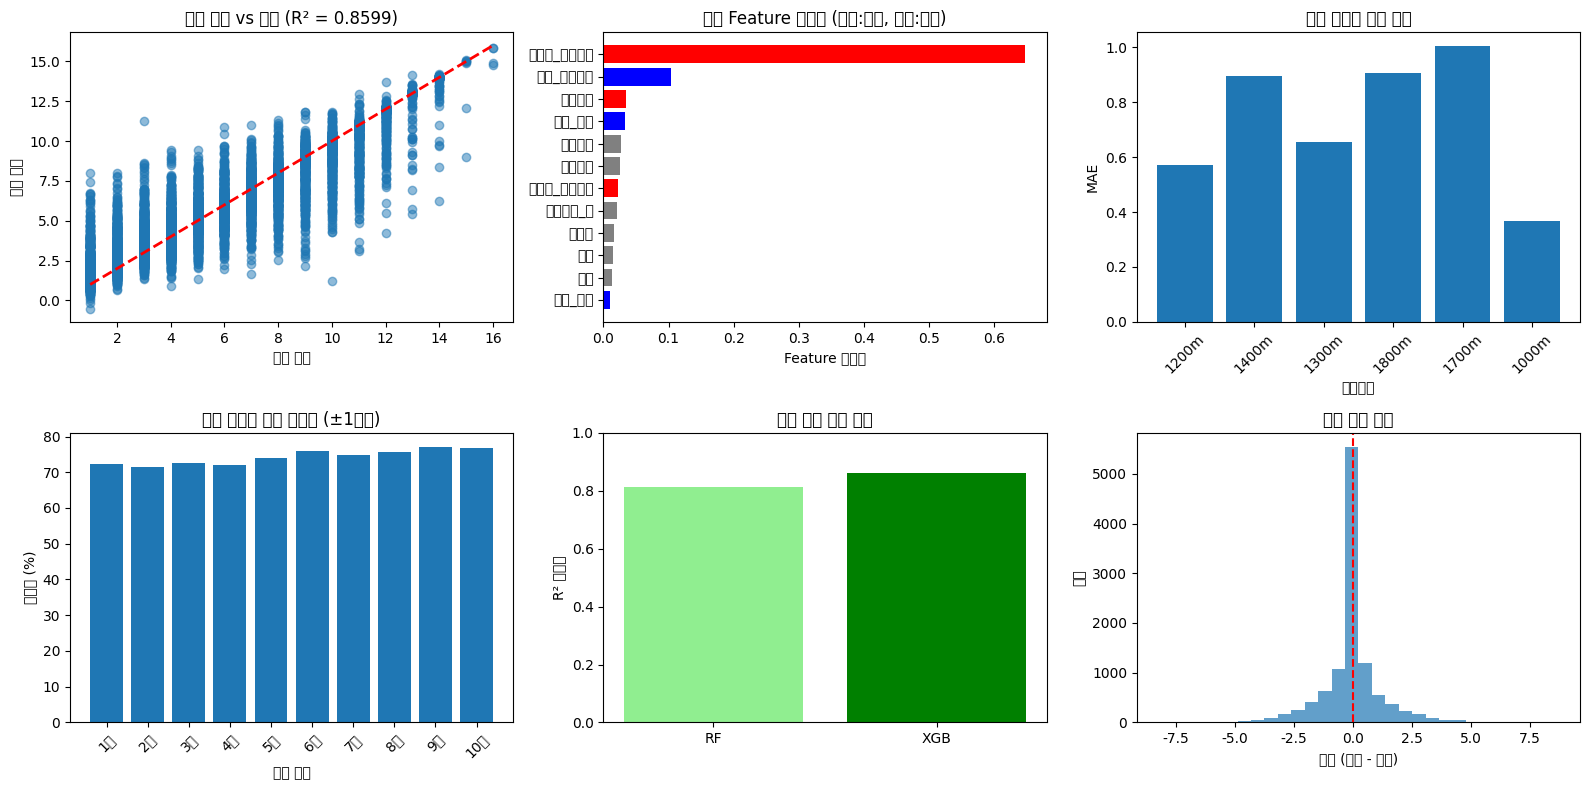


🌟 통합 모델 훈련 시작!

📊 전체통합 데이터셋 로딩 중...
   📈 총 레코드: 127,698건
   📋 총 컬럼: 27개
   🏃 경주거리 분포: {1200.0: np.int64(35019), 1400.0: np.int64(22163), 1000.0: np.int64(14195), 1300.0: np.int64(14055), 1800.0: np.int64(10107)}
   🎯 평균 순위: 5.9위
   🏆 우승률: 9.4%
   🥉 복승률: 28.1%

📏 전체통합 거리별 성과 분석...
   📊 주요 거리별 성과:
       800m: 6372경주, 평균 5.4위, 우승률 10.0%
       900m: 4929경주, 평균 5.4위, 우승률 10.0%
      1000m: 14195경주, 평균 5.7위, 우승률 10.0%
      1110m: 6658경주, 평균 5.6위, 우승률 10.0%
      1200m: 35019경주, 평균 6.1위, 우승률 9.0%
      1300m: 14055경주, 평균 6.0위, 우승률 9.0%
      1400m: 22163경주, 평균 6.1위, 우승률 9.0%
      1600m: 7356경주, 평균 6.0위, 우승률 9.0%

🌟 통합 모델 특별 분석...
   📊 경마장별 데이터 분포:
      서울: 54,762건 (42.9%)
      부산: 38,865건 (30.4%)
      제주: 34,071건 (26.7%)
   🎯 경마장별 평균 성과:
      부산: 평균 6.2위, 우승률 9.0%
      서울: 평균 6.1위, 우승률 9.2%
      제주: 평균 5.5위, 우승률 10.1%
   🏃 경마장별 주요 거리:
      서울: 1200m(18901), 1400m(11887), 1300m(9035)
      부산: 1200m(12444), 1400m(8844), 1600m(5561)
      제주: 1000m(10065), 1110m(6658), 800m(6372)

⚙

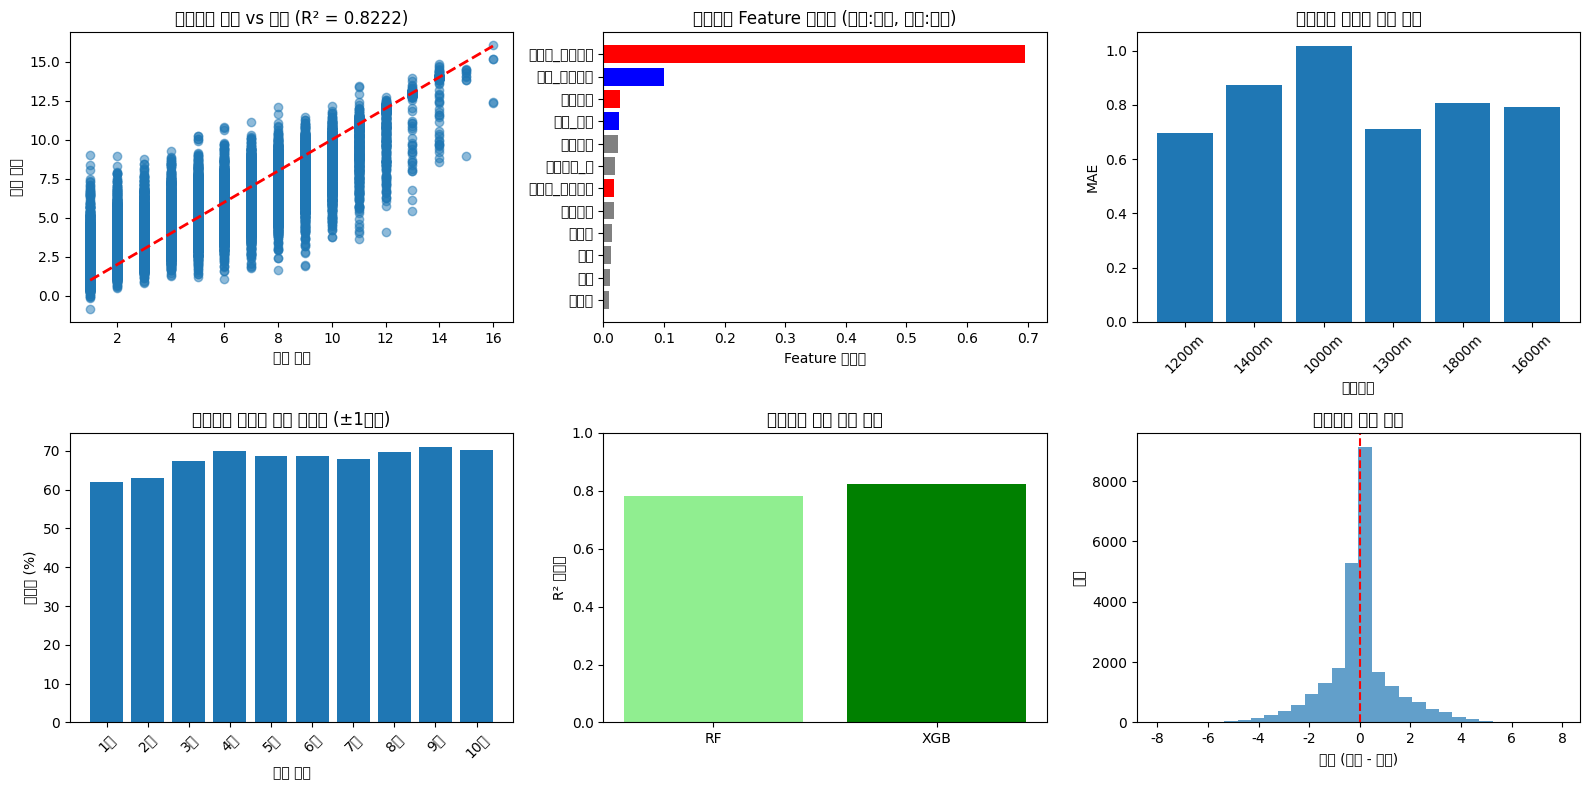


📊 경마장별 모델 성능 비교 리포트 (경주거리 포함)
🏆 성능 순위:
   1.   서울: R² 0.8599, MAE 0.734 (xgboost, 거리F:3개)
   2.   부산: R² 0.8415, MAE 0.774 (xgboost, 거리F:3개)
   3. 전체통합: R² 0.8222, MAE 0.856 (xgboost, 거리F:3개)
   4.   제주: R² 0.6700, MAE 1.212 (xgboost, 거리F:3개)

📊 전체 평균:
   평균 R² 스코어: 0.7984
   평균 MAE: 0.894
   평균 거리 Feature: 3.0개

🏃 거리 관련 Feature 중요도 분석:
   부산: 최고 거리F '거리별_조합순위' (0.6852), 총합 0.7337
   제주: 최고 거리F '거리별_조합순위' (0.6026), 총합 0.6718
   서울: 최고 거리F '거리별_조합순위' (0.6478), 총합 0.7059
   전체통합: 최고 거리F '거리별_조합순위' (0.6964), 총합 0.7406


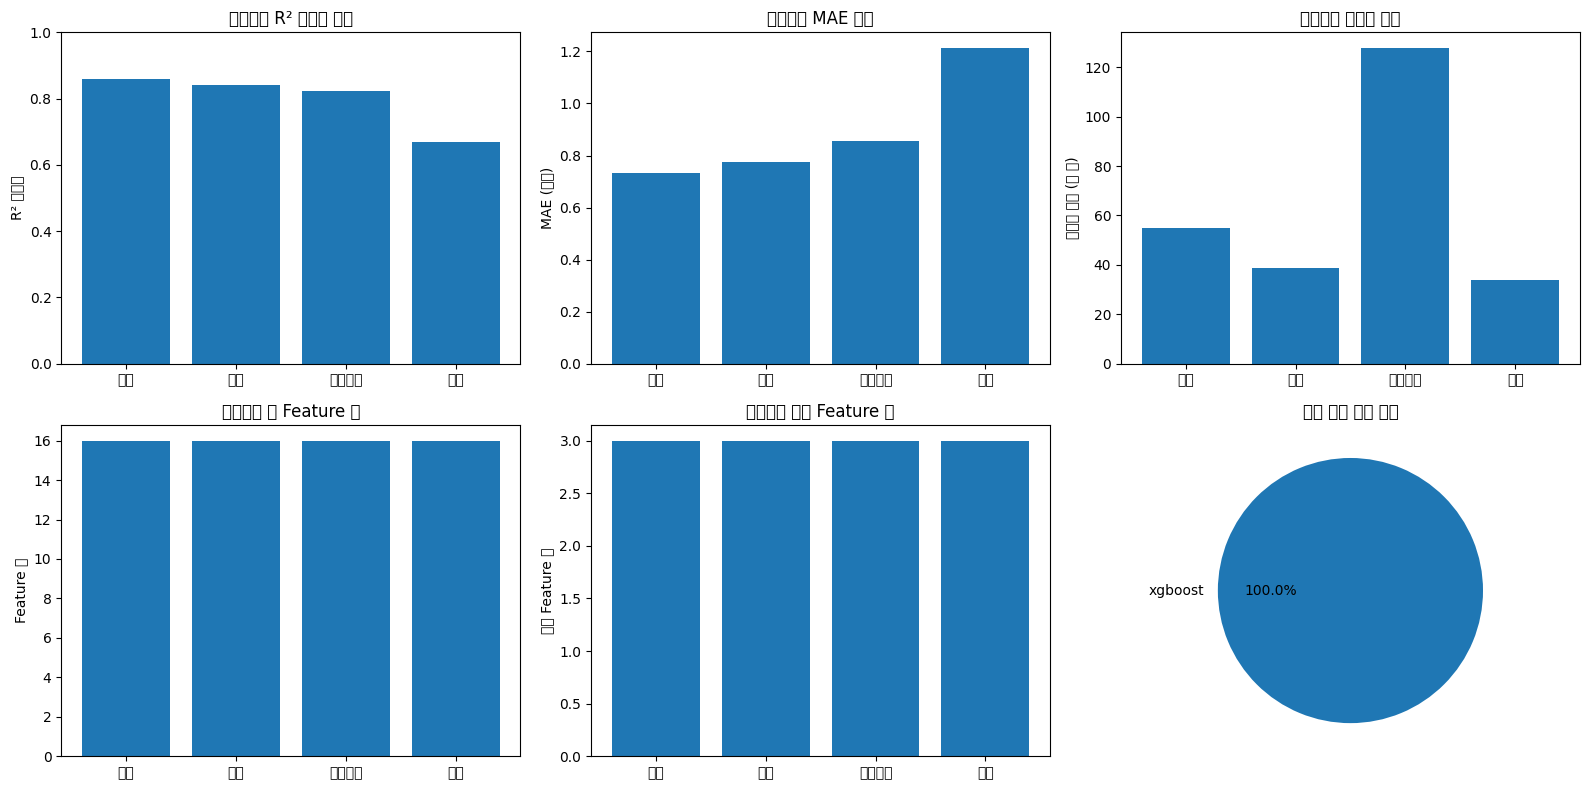


💾 모델 저장 및 다운로드 중...
✅ 개별 부산 모델 저장: busan_model.pkl
✅ 개별 제주 모델 저장: jeju_model.pkl
✅ 개별 서울 모델 저장: seoul_model.pkl
✅ 통합 전체통합 모델 저장: combined_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🎉 모든 모델 + 정보 파일 다운로드 완료!

🎉 모든 모델 훈련 완료!
📦 다운로드된 파일들:
   - seoul_model.pkl (서울 개별)
   - busan_model.pkl (부산 개별)
   - jeju_model.pkl (제주 개별)
   - combined_model.pkl (전체 통합) 🌟
   - model_info.json (모델 정보)

🏆 총 4개 모델 생성 완료!


In [ ]:
main()